In [9]:
import numpy as np
import rasterio
import plotly.graph_objects as go
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [10]:
try:
    image_rgb = np.load('output_image_rgb.npy')
    masks = np.load('output_masks.npy')
    class_ids = np.load('output_class_ids.npy')
    (H, W, _) = image_rgb.shape
    print(f"Downloaded, sizes: {H}x{W}")
except FileNotFoundError:
    print("File not found")

Downloaded, sizes: 520x779


In [11]:
DSM_PATH = "data/test_image3.tif"
try:
    with rasterio.open(DSM_PATH) as src:
        dsm_data = src.read(1)

        if dsm_data.shape != (H, W):
            print(f" DSM {dsm_data.shape} not like RGB {(H, W)}.")

except FileNotFoundError:
    print(f"File not found")

In [12]:
labels_map = np.zeros((H, W), dtype=np.uint8)

for i, class_id in enumerate(class_ids):
    mask = masks[i]
    labels_map[mask] = class_id + 1

In [13]:
interest_mask = (labels_map > 0)

indices_y, indices_x = np.where(interest_mask)

num_points = len(indices_y)
max_points_for_plot = 300_000

In [14]:
if num_points == 0:
    print("no points found")
elif num_points > max_points_for_plot:
    print(f"Found {num_points}")
    step = num_points // max_points_for_plot
    sampled_indices = (indices_y[::step], indices_x[::step])
else:
    sampled_indices = (indices_y, indices_x)

In [15]:
plot_x = sampled_indices[1]
plot_y = sampled_indices[0]
plot_z = dsm_data[sampled_indices]
plot_colors_rgb = image_rgb[sampled_indices]
plot_labels = labels_map[sampled_indices]

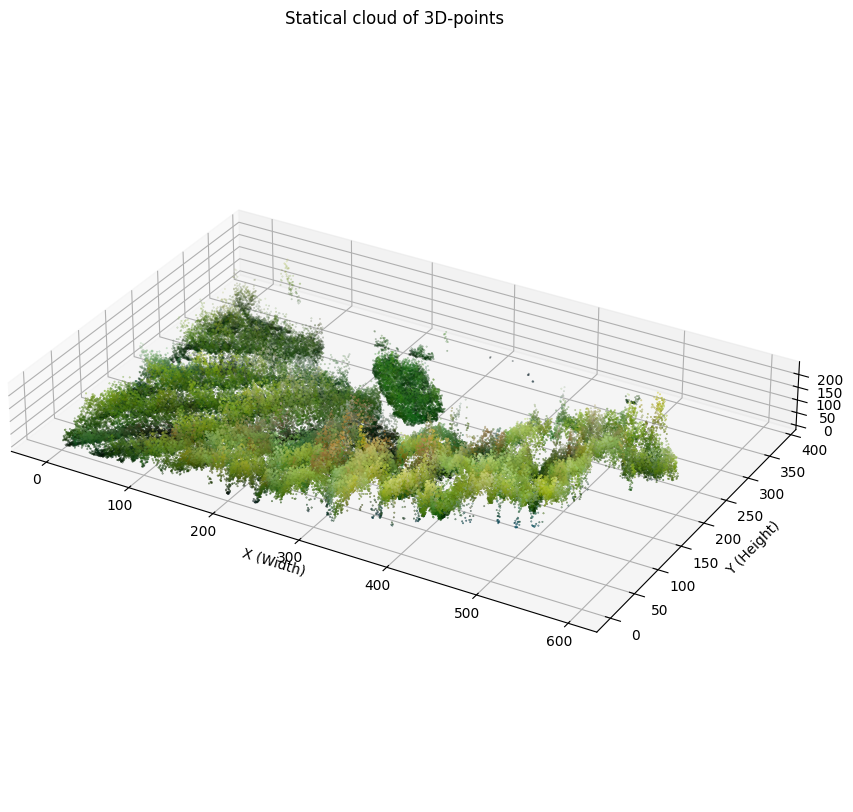

In [16]:
if 'plot_x' in locals():
    normalized_colors = plot_colors_rgb / 255.0

    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(
        plot_x,
        plot_y,
        plot_z,
        c=normalized_colors,
        s=0.5,
        marker='.'
    )

    ax.set_title('Statical cloud of 3D-points')
    ax.set_xlabel('X (Width)')
    ax.set_ylabel('Y (Height)')
    ax.set_zlabel('Z (Elevation)')

    ax.set_box_aspect((np.ptp(plot_x), np.ptp(plot_y), np.ptp(plot_z) * 0.3))

    plt.show()
else:
    print("error")

In [17]:
def save_to_ply(filename, plot_x, plot_y, plot_z, plot_colors_rgb):

    num_points = len(plot_x)
    if num_points == 0:
        return

    if plot_colors_rgb.dtype != np.uint8:
        plot_colors_rgb = (plot_colors_rgb * 255).astype(np.uint8)

    points_data = np.stack([
        plot_x,
        plot_y,
        plot_z,
        plot_colors_rgb[:, 0],
        plot_colors_rgb[:, 1],
        plot_colors_rgb[:, 2]
    ], axis=1)

    header = f"""ply
format ascii 1.0
element vertex {num_points}
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
"""

    try:
        np.savetxt(
            filename,
            points_data,
            fmt="%f %f %f %d %d %d",
            header=header.strip(),
            comments=''
        )
        print(f"All saved to {filename}")
    except Exception as e:
        print(f"error {e}")

In [18]:
if 'plot_x' in locals():
    save_to_ply('point_cloud.ply', plot_x, plot_y, plot_z, plot_colors_rgb)

All saved to point_cloud.ply
